In [8]:
import os
import random
import pandas as pd
import re
import src.constants
import os
import requests
import pandas as pd
import multiprocessing
import time
from time import time as timer
from tqdm import tqdm
import numpy as np
from pathlib import Path
from functools import partial
import requests
import urllib
from PIL import Image
import requests
from PIL import Image
import numpy as np
from io import BytesIO
import cv2
import matplotlib.pyplot as plt


In [3]:
class ImageDataGenerator:
    def __init__(self, batch_size, image_link, image_shape):
        self.batch_size = batch_size
        self.image_links = image_link
        self.image_shape = image_shape

    def __len__(self):
        return len(self.image_links) // self.batch_size

    def __getitem__(self, idx):
        batch_links = self.image_links[idx * self.batch_size:(idx + 1) * self.batch_size]
        self.batch = []
        for link in batch_links:
            response = requests.get(link)
            if response.status_code == 200:
                # Open the image using Pillow
                image = Image.open(BytesIO(response.content))
                # Convert the image to a NumPy array
                image_array = np.array(image)
                if image_array.ndim == 2:
                    # Convert grayscale to RGB
                    image_array = np.stack([image_array] * 3, axis=-1)
                # Resize the image
                img = cv2.resize(image_array, self.image_shape)
                img = img / 255.0
                self.batch.append(img)
        return np.array(self.batch)

In [2]:
# Load train and test data
train_df = pd.read_csv('./dataset/train.csv')
test_df = pd.read_csv('./dataset/test.csv')


train_image_links = train_df['image_link'].tolist()
test_image_links = test_df['image_link'].tolist()

# Download images
train_folder = './images/train'
test_folder = './images/test'

In [4]:
image_shape = (512, 512)
batch_size = 16

train_generator = ImageDataGenerator(batch_size, train_image_links, image_shape)
test_generator = ImageDataGenerator(batch_size, test_image_links, image_shape)

batch_1 = test_generator.__getitem__(0)
print(batch_1.shape)

(16, 512, 512, 3)


In [6]:
batch_1 = test_generator.__getitem__(1)
batch_1[0].shape

(512, 512, 3)

(-0.5, 511.5, 511.5, -0.5)

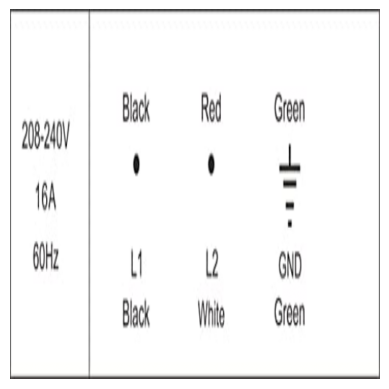

In [9]:
plt.imshow(batch_1[3])
plt.axis('off')

In [5]:
# check gpu
import torch
print(torch.cuda.is_available())
print(torch.cuda.device(0))
print(torch.cuda.device_count())

from PIL import Image
import torchvision.transforms as transforms

# Assuming this transformation function is defined as
def augment_image(image):
    augmentations = transforms.Compose([
        transforms.RandomRotation(45),
        transforms.ToTensor()
    ])
    image = augmentations(image)
    return transforms.ToPILImage()(image)


True
1


In [6]:
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet101

# Load the pre-trained model
model = deeplabv3_resnet101(pretrained=True)
model.eval()

def segment_image(image):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension
    
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    
    output_predictions = output.argmax(0).byte().cpu().numpy()
    return output_predictions


c:\Program Files\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
import pytesseract
from PIL import Image

def recognize_text(image):
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    text = pytesseract.image_to_string(image)
    return text


def preprocess_image(image_link):
    response = requests.get(image_link)
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content)).convert("RGB")  # Ensure RGB format
        image = augment_image(image)  # Apply augmentation
        return image

def extract_text_from_image(image):
    segmented_image = segment_image(image)  # Process image
    text = recognize_text(image)  # Extract text
    return text

image_link = 'https://m.media-amazon.com/images/I/41-NCxNuBxL.jpg'
image = preprocess_image(image_link)
# show image
image.show()
text = extract_text_from_image(image)
print(text)


KeyboardInterrupt: 